### 3.6. Расчёт CAC и ROI в Python



Аналитики получают данные о затратах на рекламу в CSV-файле или Excel-таблице. Обычно в таких данных есть:

- дата оплаты рекламы,
- идентификатор источника или рекламной кампании,
- стоимость рекламы.

Книжный онлайн-магазин «Читать не вредно» хранит данные о рекламных расходах в файле `ad_costs.csv`. Откроем и изучим его.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

# загружаем данные о тратах на рекламу
costs = pd.read_csv('https://code.s3.yandex.net/datasets/ad_costs_new.csv')

# преобразуем данные о времени
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

costs.head(5)

,dt,channel,costs
0,2019-05-01,AnotherSource,1826.0
1,2019-05-02,AnotherSource,1443.0
2,2019-05-03,AnotherSource,1508.0
3,2019-05-04,AnotherSource,1911.0
4,2019-05-05,AnotherSource,1837.0


Структура типичная:

- `dt` — дата проведения рекламной кампании,
- `channel` — рекламный источник,
- `costs` — стоимость рекламы.

#### Рассчитываем CAC

Чтобы рассчитать и проанализировать CAC, добавим данные о тратах на рекламу в пользовательские профили.

###### Как рассчитать CAC в Python

- Передать функции для создания профилей данные о тратах на рекламу.
- Объединить данные о тратах на рекламу и новых пользователях.
- Вычислить CAC: разделить рекламные расходы на количество новых пользователей.
- Добавить CAC для каждой даты привлечения и источника в профили.

 

Дополним функцию для создания пользовательских профилей `get_profiles()` из темы «Когортный анализ»: введём параметр `ad_costs`, посчитаем количество привлечённых пользователей для каждой даты и источника и сопоставим данные. 

Если пользователь впервые перешёл на сайт «Читать не вредно» из рекламного источника в день проведения рекламной кампании, то, скорее всего, это «платный» пользователь, и мы можем рассчитать стоимость его привлечения.

In [2]:
# добавляем параметр ad_costs — траты на рекламу
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [3]:
sessions = pd.read_csv('https://code.s3.yandex.net/datasets/sessions.csv')  # сессии
orders = pd.read_csv('https://code.s3.yandex.net/datasets/book_orders.csv')  # данные о покупках
events = pd.read_csv('https://code.s3.yandex.net/datasets/events.csv')  # данные о событиях

# преобразуем данные о времени
sessions['session_start'] = pd.to_datetime(sessions['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
events['event_time'] = pd.to_datetime(events['event_time'])

profiles = get_profiles(sessions, orders, events, costs)

profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,10964006,2019-05-12 04:50:17,Yandex,Mac,Germany,2019-05-12,2019-05-01,True,0.249238
1,12358165,2019-05-10 23:16:24,Yandex,iPhone,United States,2019-05-10,2019-05-01,False,0.239416
2,12545358,2019-05-05 19:22:46,Organic,Mac,United States,2019-05-05,2019-05-01,False,0.000000
3,16165560,2019-05-10 20:29:59,Yandex,PC,United States,2019-05-10,2019-05-01,False,0.239416
4,17733464,2019-05-12 11:08:25,Organic,iPhone,France,2019-05-12,2019-05-01,True,0.000000


В профилях появился новый столбец `acquisition_cost` со стоимостью привлечения каждого посетителя сайта «Читать не вредно». 

Выясним, как меняется стоимость привлечения для каждого источника от когорты к когорте. Для этого построим сводную таблицу, в которой названиями строк будут даты привлечения пользователей, названиями столбцов — каналы привлечения, а значениями — средний CAC, и построим по ней график истории изменений.

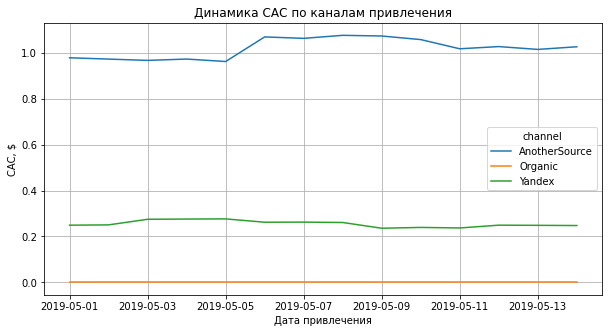

In [4]:
# строим график истории изменений CAC по каналам привлечения

profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Стоимость привлечения «органических» пользователей во всех когортах равна нулю, потому что они перешли на сайт «Читать не вредно» самостоятельно, а не благодаря рекламе. Привлечение одного пользователя из рекламной сети «Яндекса» обошлось компании в среднем в 25 центов, а из AnotherSource — примерно в $1.

#### Рассчитываем ROI

Разделив LTV на CAC, получим ROI — возврат на инвестиции. Однако есть тонкость: при расчёте CAC важно учитывать момент и горизонт анализа из расчёта LTV.

Чтобы вычислить ROI по каждому каналу привлечения, сначала найдём «пожизненную ценность» пользователей «Читать не вредно» с разбивкой по каналам привлечения.

In [5]:
# определим функцию get_ltv() из предыдущих уроков для расчёта LTV
def get_ltv(
    profiles,  # Шаг 1. Получить профили и данные о покупках
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Шаг 2. Добавить данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['user_id', 'event_dt', 'revenue']],
        on='user_id',
        how='left',
    )

    # Шаг 3. Рассчитать лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 3. Построить таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Шаг 4. Посчитать сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Шаг 5. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 6. Объединить размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 7. Посчитать LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,12575,0.305974,0.362008,0.416706,0.455056,0.482119,0.504817,0.531809
Organic,35273,0.494700,0.625516,0.723143,0.789780,0.849941,0.899009,0.936868
Yandex,24045,0.413276,0.515684,0.596086,0.649590,0.696990,0.742361,0.782424


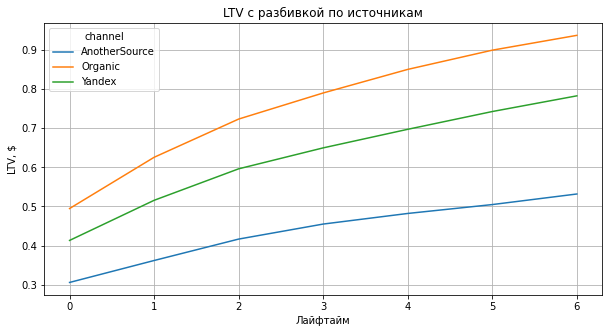

In [6]:
# находим LTV с разбивкой по каналам привлечения
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, orders, datetime(2019, 5, 13).date(), 7, dimensions=['channel']
)

# таблица LTV
display(ltv)

# кривые LTV
report = ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по источникам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

Отфильтруем пользовательские профили методом `query()`: возьмём лишь те, что участвуют в расчёте LTV. Результат сохраним в новой переменной — `ltv_profiles`.

In [7]:
# находим максимальную дату привлечения из сырых данных LTV
max_acquitision_dt = ltv_raw['dt'].max()
# отсекаем профили, которые «старше» этой даты
ltv_profiles = profiles.query('dt <= @max_acquitision_dt')

# оставшееся число пользователей на каждый лайфтайм
ltv_profiles.groupby('dt').agg({'user_id': 'nunique'})

,user_id
dt,
2019-05-01,10369
2019-05-02,8556
2019-05-03,9029
2019-05-04,11426
2019-05-05,11155
2019-05-06,11554
2019-05-07,9804


Рассчитаем средний CAC по каждому каналу привлечения. Для этого сгруппируем отфильтрованные профили и применим функцию `mean()` к значениям столбца `acquisition_cost`. Сохраним результат в переменную `cac`, изменив название столбца `acquisition_cost` на `cac`.

In [8]:
# считаем средний CAC по каналам привлечения

cac = (
    ltv_profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac

,cac
channel,
AnotherSource,0.999141
Organic,0.000000
Yandex,0.264984


С предварительными расчётами всё — можно считать ROI. Разделим каждую ячейку из таблицы LTV на соответствующую ячейку в столбце `cac` из таблицы CAC, вызвав метод `div()` и передав параметру `axis` значение `0`.

In [9]:
roi = ltv.div(cac['cac'], axis=0)
roi

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,1.258581e+04,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Organic,inf,inf,inf,inf,inf,inf,inf,inf
Yandex,9.074137e+04,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


Столбец c размерами когорт «сломался», а ROI органических пользователей устремился в бесконечность — из-за деления на ноль.

Затраты на привлечение органических пользователей нулевые, поэтому они всегда окупаются. А раз так, исключим их — удалим из результата все строки, в которых размер когорты равен бесконечности, применяя метод `isin()` и оператор `~`. Сравнивать значения с бесконечностью в Python позволяет переменная `inf` из библиотеки `numpy`.


In [10]:
roi = roi[~roi['cohort_size'].isin([np.inf])]
roi

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,12585.809284,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Yandex,90741.367370,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


Восстановим столбец с размерами когорт после деления на CAC.

In [11]:
roi.loc[:, 'cohort_size'] = ltv['cohort_size']
roi

C:\Users\okean\AppData\Local\Temp\ipykernel_11396\149938222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roi.loc[:, 'cohort_size'] = ltv['cohort_size']


,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,
AnotherSource,12575,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Yandex,24045,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


Таблица ROI готова. Построим кривые ROI и добавим на график уровень окупаемости, вызвав функцию `axhline()` из библиотеки `matplotlib`.

Её параметры:

- `y` — координата линии по вертикальной оси,
- `color` — цвет линии,
- `linestyle` — стиль линии,
- `label` — подпись.

Уровень окупаемости установим на уровне `1`, линию сделаем красной (`color='red'`) и пунктирной (`linestyle='--'`). Чтобы добавить её в легенду, вызовем метод `legend()` библиотеки `matplotlib`.


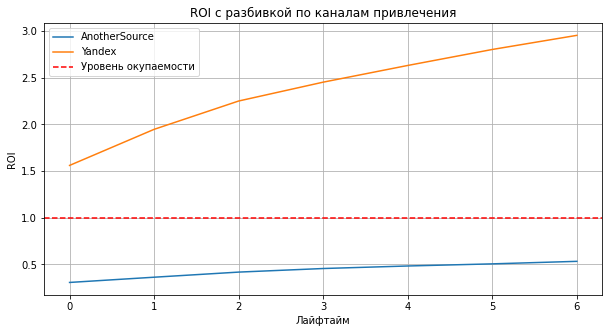

In [12]:
report = roi.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

Судя по графику, реклама в «Яндексе» окупилась в среднем на 200%, а вот реклама в `AnotherSource` не окупилась вовсе.

## Функция для расчёта LTV и ROI

Чтобы всякий раз не повторять действия выше при расчёте ROI по новым данным, добавим их в функцию для расчёта пожизненной ценности `get_ltv()`:

- рассчитаем CAC,
- разделим LTV на CAC,
- удалим строки с бесконечным ROI.


In [13]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

Вызовем обновлённую функцию `get_ltv()` и сверим ROI.

In [14]:
# рассчитываем LTV и ROI

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 5, 13).date(), 7, dimensions=['channel']
)

roi  # таблица ROI

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0
channel,,,,,,,,,
AnotherSource,12575,0.999141,0.306237,0.362319,0.417064,0.455447,0.482534,0.505251,0.532266
Yandex,24045,0.264984,1.559627,1.946097,2.249517,2.451433,2.630310,2.801531,2.952722


Данные полностью совпадают с результатами расчётов вне функции.

Бонус вызова `get_ltv()` — таблица динамики ROI в переменной `roi_history`.

In [15]:
roi_history

cohort_size       cac       0.0       1.0       2.0  \
channel       dt                                                                
AnotherSource 2019-05-01         1867  0.978040  0.249233  0.298970  0.416544   
              2019-05-02         1484  0.972372  0.260742  0.343756  0.426750   
              2019-05-03         1560  0.966667  0.377228  0.450033  0.494397   
              2019-05-04         1965  0.972519  0.364029  0.418864  0.452810   
              2019-05-05         1910  0.961780  0.406445  0.439042  0.463489   
              2019-05-06         2051  1.068893  0.264540  0.319167  0.351489   
              2019-05-07         1738  1.062658  0.230202  0.284238  0.341545   
Yandex        2019-05-01         3404  0.249119  1.457111  2.124623  2.596604   
              2019-05-02         2933  0.250511  1.458932  2.018564  2.563280   
              2019-05-03         3031  0.274909  1.485317  1.706895  1.935674   
              2019-05-04         3861  0.275855  1.670023  1.984959  2.253888   
              2019-05-05         3744  0.276542  1.755461  1.972339  2.112124   
              2019-05-06         3872  0.262093  1.559914  2.024132  2.310310   
              2019-05-07         3200  0.262582  1.443239  1.763925  2.026426   

                               3.0       4.0       5.0       6.0  
channel       dt                                                  
AnotherSource 2019-05-01  0.468467  0.509458  0.550997  0.616632  
              2019-05-02  0.499390  0.547803  0.599674  0.651552  
              2019-05-03  0.544092  0.560637  0.583800  0.600345  
              2019-05-04  0.492548  0.519184  0.524406  0.532240  
              2019-05-05  0.477071  0.485220  0.490653  0.504235  
              2019-05-06  0.379715  0.404753  0.411581  0.434343  
              2019-05-07  0.365862  0.392880  0.428004  0.444215  
Yandex        2019-05-01  2.949670  3.279198  3.639328  3.975920  
              2019-05-02  2.912365  3.212548  3.539898  3.846996  
              2019-05-03  2.080600  2.212349  2.308167  2.387219  
              2019-05-04  2.356961  2.483459  2.563106  2.610896  
              2019-05-05  2.251976  2.310776  2.413039  2.480541  
              2019-05-06  2.507979  2.680078  2.866957  3.049008  
              2019-05-07  2.210523  2.400559  2.501516  2.597724

По таблице динамики ROI можно оценить динамику CAC. 

Методом `pivot_table()` создадим сводную таблицу, в которой названиями строк окажутся даты привлечения пользователей, названиями столбцов — каналы, а значениями — средняя стоимость привлечения. По этой таблице построим график истории изменений, вызвав метод `plot()`.


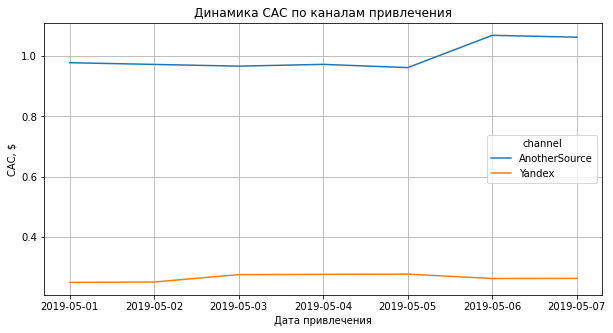

In [16]:
# строим график истории изменений CAC

roi_history.pivot_table(
    index='dt', columns='channel', values='cac', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Кроме того, таблица динамики ROI позволяет оценить изменения окупаемости в зависимости от канала и даты привлечения.

Построим график динамики ROI первого дня с разбивкой по каналам. Для этого создадим сводную таблицу, в которой названиями строк окажутся даты привлечения пользователей, названиями столбцов — каналы, а значениями — среднее значение ROI по столбцу `0`, в котором лежат данные за нулевой лайфтайм, или первый день «жизни».


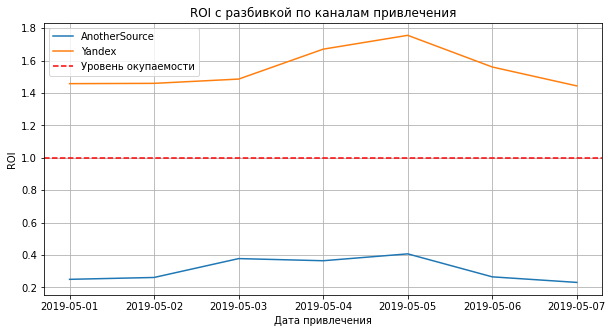

In [17]:
# строим график истории изменения ROI первого дня

roi_history.pivot_table(
    index='dt', columns='channel', values=0, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

График динамики ROI показывает, что реклама «Читать не вредно» в «Яндексе» стабильно окупалась на 140–180% уже в день привлечения пользователей, а рекламе из `AnotherSource` не хватало до окупаемости примерно 60–80%.